# Parameter Tuning for KNN-TD(0)

*Author: Maleakhi Agung Wijaya*  
*Date Created: 05/01/2018*

In [1]:
import random
import math
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, clear_output

## Mountain Car Environment 

In [2]:
class MountainCarEnvironment:
    """
    Description: Environment for Mountain Car problem, adapted from Sutton and Barto's Introduction to Reinforcement Learning.
    Author: Maleakhi Agung Wijaya
    """
    VELOCITY_BOUNDARIES = (-0.07, 0.07)
    POSITION_BOUNDARIES = (-1.2, 0.6) 
    
    INITIAL_VELOCITY = 0.0
    INITIAL_POSITION = -0.5
    
    REWARD_STEP = -1
    REWARD_TERMINAL = 0
   
    # Constructor for MountainCarEnvironment
    # Input: agent for the MountainCarEnvironment
    # Output: MountainCarEnvironment object
    def __init__(self, car):
        self.car = car
        self.reset()
        
    # Compute next state (feature)
    # Output: [new velocity, new position]
    def nextState(self, action):
        # Get current state (velocity, position) and the action chosen by the agent
        velocity = self.car.state[0]
        position = self.car.state[1]
        
        # Calculate the new velocity and new position
        velocity += action * 0.001 + math.cos(3*position) * (-0.0025)
        # Consider boundary for velocity
        if (velocity < MountainCarEnvironment.VELOCITY_BOUNDARIES[0]):
            velocity = MountainCarEnvironment.VELOCITY_BOUNDARIES[0]
        elif (velocity > MountainCarEnvironment.VELOCITY_BOUNDARIES[1]):
            velocity = MountainCarEnvironment.VELOCITY_BOUNDARIES[1]
            
        position += velocity
        # Consider boundary for position
        if (position < MountainCarEnvironment.POSITION_BOUNDARIES[0]):
            position = MountainCarEnvironment.POSITION_BOUNDARIES[0]
            velocity = 0
        elif (position > MountainCarEnvironment.POSITION_BOUNDARIES[1]):
            position = MountainCarEnvironment.POSITION_BOUNDARIES[1]
        
        new_state = [velocity, position]
        return(new_state)
    
    # Reset to the initial state   
    def reset(self):
        self.car.state[0] = MountainCarEnvironment.INITIAL_VELOCITY
        self.car.state[1] = MountainCarEnvironment.INITIAL_POSITION
        
    # Give reward for each of the chosen action, depending on what the next state that the agent end up in
    # Output: terminal state = 0, non-terminal state = -1
    def calculateReward(self):
        # Get current position of the agent
        position = self.car.state[1]
        
        # Determine the reward given
        if (position >= MountainCarEnvironment.POSITION_BOUNDARIES[1]):
            return(MountainCarEnvironment.REWARD_TERMINAL)
        else:
            return(MountainCarEnvironment.REWARD_STEP)

## KNN-TD Agent

In [3]:
class KNNAgent:
    """
    Description: Mountain Car problem agent based on kNN-TD(0) algorithm 
    Author: Maleakhi Agung Wijaya
    """
    INITIAL_VELOCITY = 0.0
    INITIAL_POSITION = -0.5
    INITIAL_VALUE = -1
    
    ACTIONS = [-1, 0, 1]
    GAMMA = 0.995
    EPSILON = 0.05
    
    INDEX_DISTANCE = 0
    INDEX_ORIGINAL = 1
    INDEX_WEIGHT = 2
    
    REWARD_STEP = -1
    REWARD_TERMINAL = 0
    
    # Constructor
    # Input: size of the storage for previous Q values, parameters for how many neighbours which the agent will choose
    def __init__(self, size, k):
        self.state = [KNNAgent.INITIAL_VELOCITY, KNNAgent.INITIAL_POSITION]
        self.q_storage = []
        self.k = k # fixed number of nearest neighbours that we will used
        self.alpha = 1 # will be decaying and change later
        
        # Storage of the k nearest neighbour (data) and weight (inverse of distance) for a particular step
        self.knn = []
        self.weight = []
        
        # Initialise the storage with random point 
        for i in range(size):
            initial_action = random.randint(-1, 1)
            initial_state = [random.uniform(-0.07, 0.07), random.uniform(-1.2, 0.6)]
            
            # Each data on the array will consist of state, action pair + value
            data = {"state": initial_state, "value": KNNAgent.INITIAL_VALUE, "action": initial_action}
            self.q_storage.append(data)
    
    # Find all index for a given value
    # Input: value, list to search
    # Output: list of all index where you find that value on the list
    def findAllIndex(self, value, list_value):
        indices = []
        for i in range(len(list_value)):
              if (value == list_value[i]):
                    indices.append(i)
        
        return indices
    
    # Standardise feature vector given
    # Input: feature vector to be standardised
    # Output: standardised feature vector
    def standardiseState(self, state):
        standardised_state = []
        
        # The number is taken from VELOCITY_BOUNDARIES and POSITION_BOUNDARIES using normal standardisation formula
        standardised_velocity = 2 * ((state[0]+0.07) / (0.07+0.07)) - 1
        standardised_position = 2 * ((state[1]+1.2) / (0.6+1.2)) - 1
        
        standardised_state.append(standardised_velocity)
        standardised_state.append(standardised_position)
        
        return(standardised_state)
    
    # Calculate Euclidean distance between 2 vectors
    # Input: 2 feature vectors
    # Output: distance between them
    def calculateDistance(self, vector1, vector2):
        return(math.sqrt((vector1[0]-vector2[0])**2 + (vector1[1]-vector2[1])**2))
    
    # Calculate total weight
    # Input: list of weights
    # Output: total weight
    def calculateTotalWeight(self, weight_list):
        total_weight = 0
        for i in range(len(weight_list)):
            total_weight += weight_list[i][KNNAgent.INDEX_WEIGHT]
        
        return(total_weight)
    
    # Apply the kNN algorithm for feature vector and store the data point on the neighbours array
    # Input: feature vector of current state, actions array consisting of all possible actions, list that will store knn data and weights data
    # Output: vector containing the value of taking each action (left, neutral, right)
    def kNNTD(self, state, actions, knn_list, weight_list):
        approximate_action = []
        
        # Get the standardised version of state
        standardised_state = self.standardiseState(state)
        
        # Loop through every element in the storage array and only calculate for particular action
        for action in actions:
            temp = [] # array consisting of tuple (distance, original index, weight) for each point in the q_storage
            for i in range(len(self.q_storage)):
                data = self.q_storage[i]
                # Only want to calculate the nearest neighbour state which has the same action
                if (data["action"] == action):
                    vector_2 = data["state"]
                    standardised_vector_2 = self.standardiseState(vector_2)
                    distance = self.calculateDistance(standardised_state, standardised_vector_2)
                    index = i
                    weight = 1 / (1+distance**2) # weight formula
            
                    # Create the tuple and append that to temp
                    temp.append(tuple((distance, index, weight)))
                else:
                    continue
        
            # After we finish looping through all of the point and calculating the standardise distance,
            # Sort the tuple based on the distance and only take k of it and append that to the neighbours array
            # We also need to calculate the total weight to make it into valid probability that we can compute it's expectation
            sorted_temp = sorted(temp, key=lambda x: x[0])
            for i in range(self.k):
                try:
                    weight_list.append(sorted_temp[i])
                    knn_list.append(self.q_storage[sorted_temp[i][KNNAgent.INDEX_ORIGINAL]])
                except IndexError:
                    sys.exit(0)
            
            # Calculate the expected value of the action and append it to the approximate_action array
            expected_value = 0
            total_weight = self.calculateTotalWeight(weight_list[(action+1)*self.k:(action+1)*self.k + self.k])
            for i in range((action+1)*self.k, (action+1)*self.k + self.k):
                weight = weight_list[i][KNNAgent.INDEX_WEIGHT]
                probability = weight / total_weight
                expected_value += probability * knn_list[i]["value"]
                
            approximate_action.append(expected_value)
        
        return(approximate_action)
    
    # Select which action to choose, whether left, neutral, or right (using epsilon greedy)
    # Output: -1 (left), 0 (neutral), 1 (right)
    def selectAction(self):
        # First call the knn-td algorithm to determine the value of each Q(s,a) pairs
        action_value = self.kNNTD(self.state, KNNAgent.ACTIONS, self.knn, self.weight)
        
        # Use the epsilon-greedy method to choose value
        random_number = random.uniform(0.0, 1.0)
        if (random_number <= KNNAgent.EPSILON):
            action_chosen = random.randint(-1, 1)
        else:
            # Return the action with highest Q(s,a)
            possible_index = self.findAllIndex(max(action_value), action_value)
            action_chosen = possible_index[random.randrange(len(possible_index))] - 1
        
        # Only store chosen data in the knn and weight list
        # Clearance step
        chosen_knn = []
        chosen_weight = []
        for i in range(self.k*(action_chosen+1), self.k*(action_chosen+1) + self.k):
            chosen_knn.append(self.knn[i])
            chosen_weight.append(self.weight[i])
        self.knn = chosen_knn
        self.weight = chosen_weight

        return action_chosen
    
    # Calculate TD target based on Q Learning/ SARSAMAX
    # Input: Immediate reward based on what the environment gave
    # Output: TD target based on off policy Q learning
    def calculateTDTarget(self, immediate_reward):
        # Consider condition on the final state, return 0 immediately
        if (immediate_reward == KNNAgent.REWARD_TERMINAL):
            return(immediate_reward)
        
        knn_prime = []
        weight_prime = []
        action_value = self.kNNTD(self.state, KNNAgent.ACTIONS, knn_prime, weight_prime)
        
        return(immediate_reward + KNNAgent.GAMMA*max(action_value))
    
    # Q learning TD updates on every neighbours on the kNN based on the contribution that are calculated using probability weight
    # Input: Immediate reward based on what the environment gave
    def TDUpdate(self, immediate_reward, alpha):
        self.alpha = alpha
        # First, calculate the TD target
        td_target = self.calculateTDTarget(immediate_reward)
        
        # Iterate every kNN and update using Q learning method based on the weighting
        total_weight = self.calculateTotalWeight(self.weight)
        for i in range(len(self.weight)):
            index = self.weight[i][KNNAgent.INDEX_ORIGINAL]
            probability = self.weight[i][KNNAgent.INDEX_WEIGHT] / total_weight
            
            # Begin updating
            td_error = td_target - self.q_storage[index]["value"]
            self.q_storage[index]["value"] = self.q_storage[index]["value"] + self.alpha*td_error*probability
        
        self.cleanList() # clean list to prepare for another step
            
    # Clear the knn list and also the weight list
    def cleanList(self):
        self.knn = []
        self.weight = []

## Main Function

The main purpose of this program is to tune the best k parameter/ number of nearest neighbours to use for the  KNN-TD approach described and implemented on [PNA.ipynb](https://github.com/maleakhiw/Pessimistic-Neighbourhood-Aggregation-for-States-in-Reinforcement-Learning/blob/master/PNA.ipynb). The main approach that is used for this purpose is by trying k (number of nearest neighbours) starting from 4 up to considering all points as neighbours. From there, results are generated and inspected for each k which we will choose the best k leading to convergence. The environment that will be used is Mountain Car.

In [7]:
# Generate decaying alphas
# Input: minimum alpha, number of episodes
# Output: list containing alpha
def generateAlphas(minimum_alpha, n_episodes):
    return(np.linspace(1.0, MIN_ALPHA, N_EPISODES))

N_EPISODES = 50
MIN_ALPHA = 0.02
alphas = generateAlphas(MIN_ALPHA, N_EPISODES)

# Initialise the environment and the agent
size = 1000 # size of the q_storage 
k = 4 # knn parameter, this is just for initialisation, but later will be change below
agent = KNNAgent(size, k)
mountain_car_environment = MountainCarEnvironment(agent)

# Ranges of k (this is based for previous experience, simulate many times to test previous experiment whether it holds)
largest_k_chosen = 20
smallest_k_chosen = 4

# Store initial q storage
initial_q_storage = agent.q_storage

# Store number of steps for each k
k_step = [0 for i in range(20-4+1)]

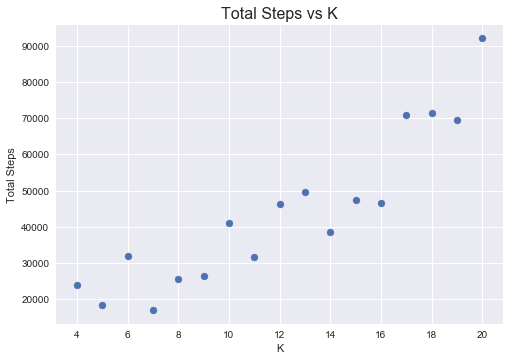

In [ ]:
for e in range(1, 5):
    for k_param in range(smallest_k_chosen, largest_k_chosen + 1):
        # Iterate the process, train the agent (training_iteration episodes)
        training_iteration = N_EPISODES
        total_step = 0
        agent.k = k_param
        agent.q_storage = initial_q_storage
        useless_k = False
        for i in range(training_iteration):
            step = 0
            alpha = alphas[i]
            mountain_car_environment.reset()
            while (True):
                action = agent.selectAction()
                next_state = mountain_car_environment.nextState(action)
        
                # Change agent current state and getting reward
                agent.state = next_state
                immediate_reward = mountain_car_environment.calculateReward()
                step += 1
        
                # Test for successful learning
                if (immediate_reward == MountainCarEnvironment.REWARD_TERMINAL):
                    agent.TDUpdate(immediate_reward, alpha)
                    total_step += step
                    break
        
                # Update using Q Learning and kNN
                agent.TDUpdate(immediate_reward, alpha)
            
                # Prevent not converge at all or too long to converge
                if (step >= 500000):
                    useless_k = True
                    total_step = sys.maxsize
                    break
                
                if (total_step > 500000):
                    useless_k = True
                    total_step = sys.maxsize
                    break
        
            if (useless_k):
                break
    
        # After finishing all episodes required, calculate how many step taken during that period
        k_step[k_param - smallest_k_chosen] = (k_step[k_param - smallest_k_chosen] * (e-1) + total_step) / e
    
        # Graph dynamically
        clear_output(wait=True)
        y = k_step
        x = np.arange(4, 4 + len(y))
        plt.scatter(x, y)
        plt.title("Total Steps vs K", fontsize=16)
        plt.xlabel("K")
        plt.ylabel("Total Steps")
    
        plt.show()

In [ ]:
print("The best k which minimise total steps is k = {}.".format(knn_step.index(min(k_step)) + smallest_k_chosen)